In [47]:
# Record of Revisions
#
# Date            Programmers                         Descriptions of Change
# ====         ================                       ======================
# 06-May-22     Amin Ghaderi                            Original code adapted from BayesFlow examples
# 13-May-22     Michael Nunez        Recovery and exploration of model-predicted EEG-RT relationships

import os
import numpy as np
from scipy import stats
from time import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numba import njit
import tensorflow as tf

from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel


def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)
    
    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data


# Use Michael Nunez's own recovery function

def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)




# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../checkpoint/N200_single_trial"
)

# Make sure the checkpoint actually loads and DOES NOT SAY "Creating network from scratch"
# Instead it should say something like "Networks loaded from checkpoint/ckpt-1000"

# Variable n_trials
def prior_N(n_min=60, n_max=300):
    """
    A prior or the number of observation (will be called internally at each backprop step).
    """

    return np.random.randint(n_min, n_max + 1)


# Experience-replay training
# losses = trainer.train_experience_replay(epochs=1000,
#                                          batch_size=32,
#                                          iterations_per_epoch=1000,
#                                          capacity=100,
#                                          n_obs=prior_N)


# Parameter recovery
n_param_sets = 100
n_samples = 5000
n_trials = 1000

np.random.seed(1)
true_params = prior(n_param_sets)
choicertEEG = batch_simulator(true_params, n_trials).astype(np.float32)
param_samples = amortizer.sample(choicertEEG, n_samples=n_samples)

# param_means = param_samples.mean(axis=0)

# true_vs_estimated(true_params, param_means, ['drift', 'boundary', 'beta', 'mu_tau_e', 'tau_m', 'sigma', 'varsigma'], filename="../true_vs_estimate/N200_single_trial")

Networks loaded from ../checkpoint/N200_single_trial/ckpt-1000


In [48]:

# Recovery when choice-RT and EEG are randomly shuffled so that they are no longer correlated
np.random.seed(1)

permuted_choicertEEG = np.zeros(choicertEEG.shape)
param_samples_from_permuted = np.zeros(param_samples.shape)
true_params_before_permuted = np.zeros(true_params.shape)

for paramset in range(n_param_sets):
    temp_params = prior(1)
    true_params_before_permuted[paramset, :] = temp_params
    temp_choicertEEG = batch_simulator(temp_params, n_trials).astype(np.float32)
    permuted_choicertEEG[paramset, :, 0] = temp_choicertEEG[0, :, 0]
    permuted_choicertEEG[paramset, :, 1] = np.random.permutation(temp_choicertEEG[0, :, 1])



# Model relationship between PERMUTED single-trial EEG and RT

param_samples_from_permuted = amortizer.sample(permuted_choicertEEG, n_samples=n_samples)

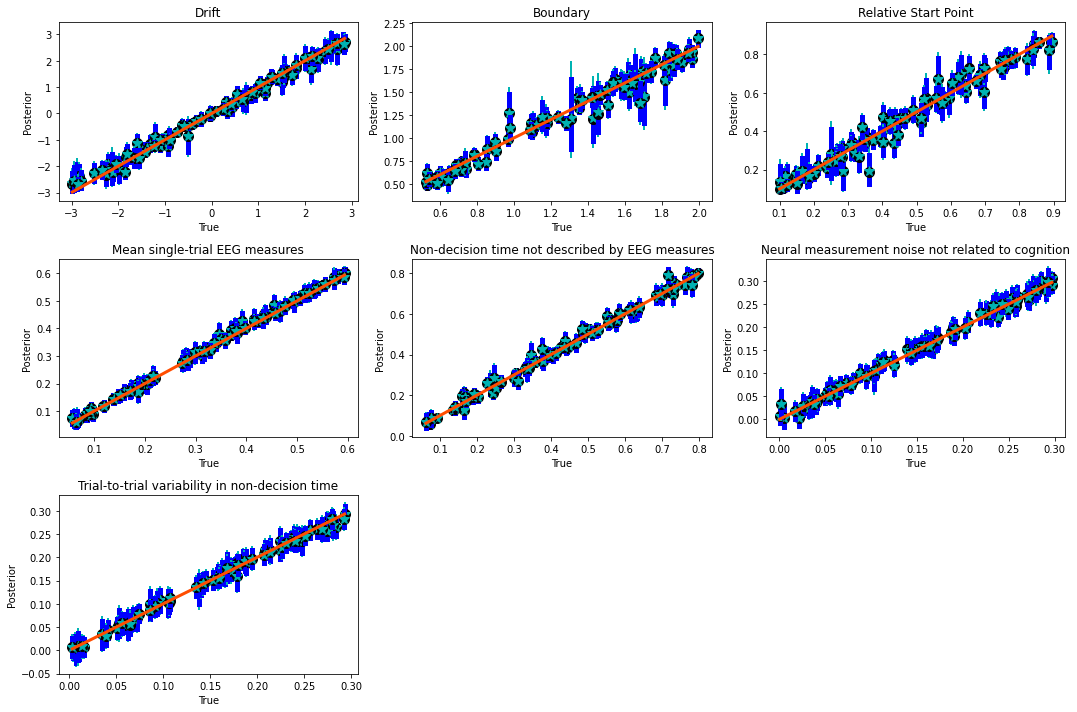

In [43]:
# Plot the results
fig=plt.figure(figsize=(15,10), tight_layout=True)

columns = 3
rows = 3

fig.add_subplot(rows, columns, 1)    
recovery(param_samples[:, :, 0].T.reshape(n_param_sets, n_samples, 1), true_params[:, 0].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Drift')

fig.add_subplot(rows, columns, 2)    
recovery(param_samples[:, :, 1].T.reshape(n_param_sets, n_samples, 1), true_params[:, 1].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Boundary')

fig.add_subplot(rows, columns, 3)    
recovery(param_samples[:, :, 2].T.reshape(n_param_sets, n_samples, 1), true_params[:, 2].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Relative Start Point')

fig.add_subplot(rows, columns, 4)    
recovery(param_samples[:, :, 3].T.reshape(n_param_sets, n_samples, 1), true_params[:, 3].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Mean single-trial EEG measures')

fig.add_subplot(rows, columns, 5)
recovery(param_samples[:, :, 4].T.reshape(n_param_sets, n_samples, 1), true_params[:, 4].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Non-decision time not described by EEG measures')

fig.add_subplot(rows, columns, 6)    
recovery(param_samples[:, :, 5].T.reshape(n_param_sets, n_samples, 1), true_params[:, 5].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Neural measurement noise not related to cognition')

fig.add_subplot(rows, columns, 7)    
recovery(param_samples[:, :, 6].T.reshape(n_param_sets, n_samples, 1), true_params[:, 6].squeeze())
plt.xlabel('True')
plt.ylabel('Posterior')
plt.title('Trial-to-trial variability in non-decision time')
plt.savefig('Figures/parameter_recovaer_non_permuted.png')

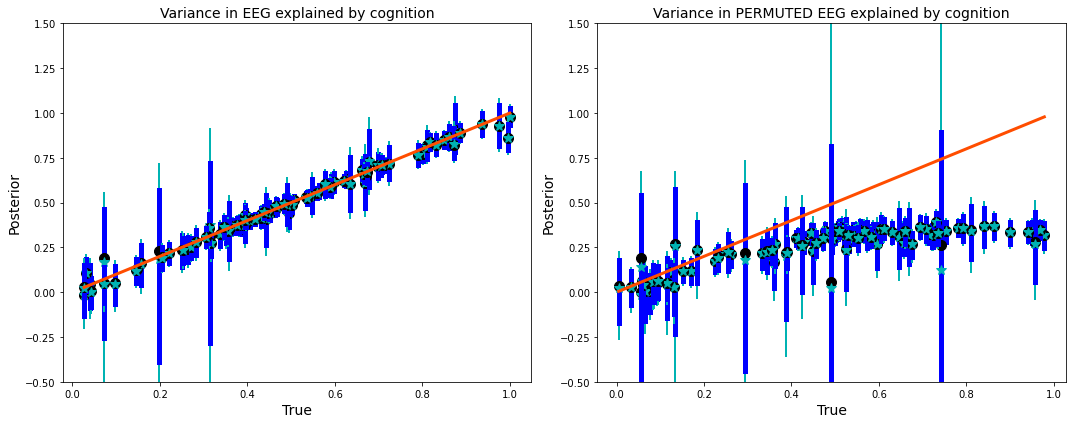

In [67]:
# Plot the results
fig=plt.figure(figsize=(15,6), tight_layout=True)

columns = 2
rows = 1

# Plot the results
fig.add_subplot(rows, columns, 1)  
true_var_explained_cogn = true_params[:, 6].squeeze() / (true_params[:, 5].squeeze() + true_params[:, 6].squeeze())
var_explained_cogn_samples  = param_samples[:, :, 6].T.reshape(n_param_sets, n_samples, 1) / ( param_samples[:, :, 5].T.reshape(n_param_sets, n_samples, 1) + param_samples[:, :, 6].T.reshape(n_param_sets, n_samples, 1) )
recovery(var_explained_cogn_samples, true_var_explained_cogn)
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.ylim(-0.5, 1.5)
plt.title('Variance in EEG explained by cognition', fontsize=14)

fig.add_subplot(rows, columns, 2)  
true_var_explained_cogn_permuted = true_params_before_permuted[:, 6].squeeze() / (true_params_before_permuted[:, 5].squeeze() + true_params_before_permuted[:, 6].squeeze())
var_explained_cogn_samples_permuted  = param_samples_from_permuted[:, :, 6].T.reshape(n_param_sets, n_samples, 1)  / ( param_samples_from_permuted[:, :, 5].T.reshape(n_param_sets, n_samples, 1) + param_samples_from_permuted[:, :, 6].T.reshape(n_param_sets, n_samples, 1) )
recovery(var_explained_cogn_samples_permuted, true_var_explained_cogn_permuted)
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.ylim(-0.5, 1.5)
plt.title('Variance in PERMUTED EEG explained by cognition', fontsize=14)
plt.savefig('Figures/permuted_nonpermuted_percentage_EEG_cognition.png', dpi=300, format='png')

plt.subplots_adjust(hspace=0, wspace=0.4)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                 1.703e+04
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:00:22   Log-Likelihood:                -70854.
No. Observations:              100000   AIC:                         1.417e+05
Df Residuals:                   99998   BIC:                         1.417e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8802      0.002    389.222      0.0

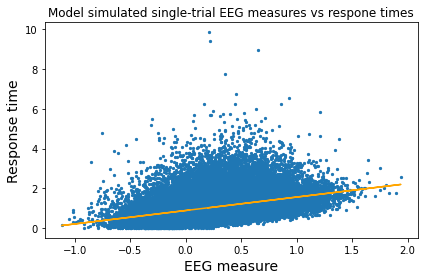

In [69]:

# Model relationship between single-trial EEG and RT
plt.figure(tight_layout=True)
RT = np.abs(choicertEEG[:,:,0].flatten())
EEG = choicertEEG[:,:,1].flatten()
plt.scatter(EEG, RT, s=5)

# Linear regression
design_matrix = np.vstack((np.ones(EEG.shape), EEG)).T
simple_regression = sm.OLS(RT, design_matrix)
regress_results = simple_regression.fit()
print(regress_results.summary())

plt.plot(EEG, regress_results.predict(), color='orange')


plt.xlabel('EEG measure', fontsize=14)
plt.ylabel('Response time', fontsize=14)
plt.title('Model simulated single-trial EEG measures vs respone times')
plt.savefig('Figures/simulated_single-trial_EEG_RT_scatter.png', dpi=300, format='png')

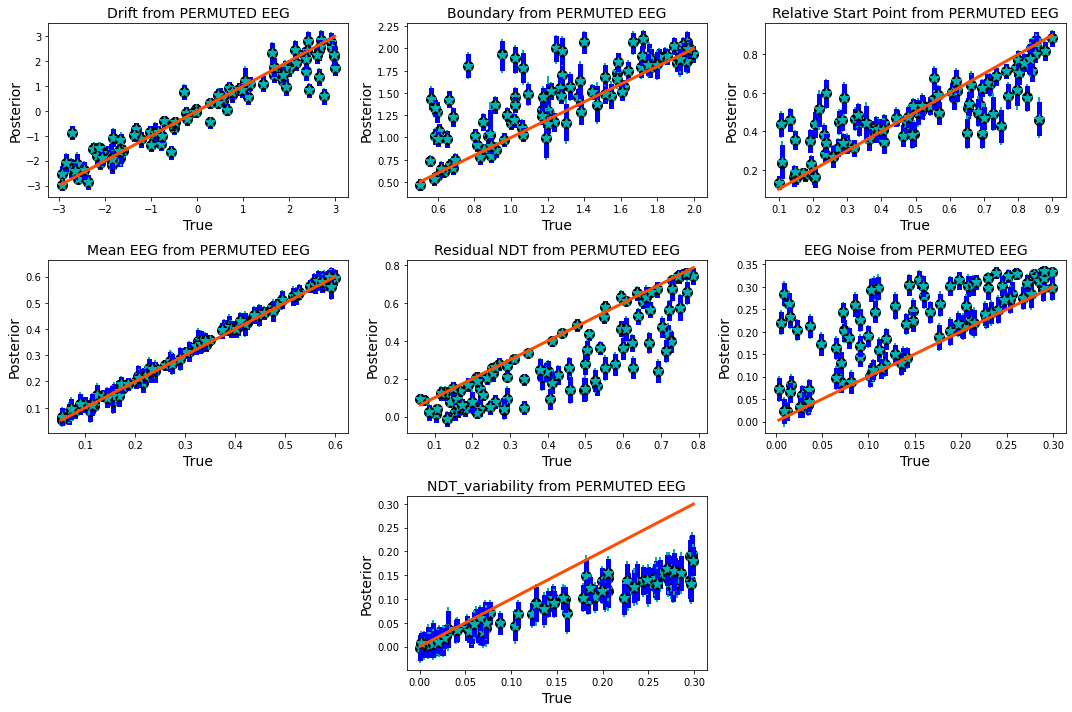

In [46]:
# Plot the results
fig=plt.figure(figsize=(15,10), tight_layout=True)


columns = 3
rows = 3


param_samples_from_permuted = amortizer.sample(permuted_choicertEEG, n_samples=n_samples)


# Plot the results
fig.add_subplot(rows, columns, 1)    
recovery(param_samples_from_permuted[:, :, 0].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 0].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('Drift from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 2)    
recovery(param_samples_from_permuted[:, :, 1].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 1].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('Boundary from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 3)    
recovery(param_samples_from_permuted[:, :, 2].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 2].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('Relative Start Point from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 4)    
recovery(param_samples_from_permuted[:, :, 3].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 3].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('Mean EEG from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 5)    
recovery(param_samples_from_permuted[:, :, 4].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 4].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('Residual NDT from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 6)    
recovery(param_samples_from_permuted[:, :, 5].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 5].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('EEG Noise from PERMUTED EEG', fontsize=14)

fig.add_subplot(rows, columns, 8)    
recovery(param_samples_from_permuted[:, :, 6].T.reshape(n_param_sets, n_samples, 1), true_params_before_permuted[:, 6].squeeze())
plt.xlabel('True', fontsize=14)
plt.ylabel('Posterior', fontsize=14)
plt.title('NDT_variability from PERMUTED EEG', fontsize=14)
plt.savefig('Figures/permuted_parameter_recovery.png')

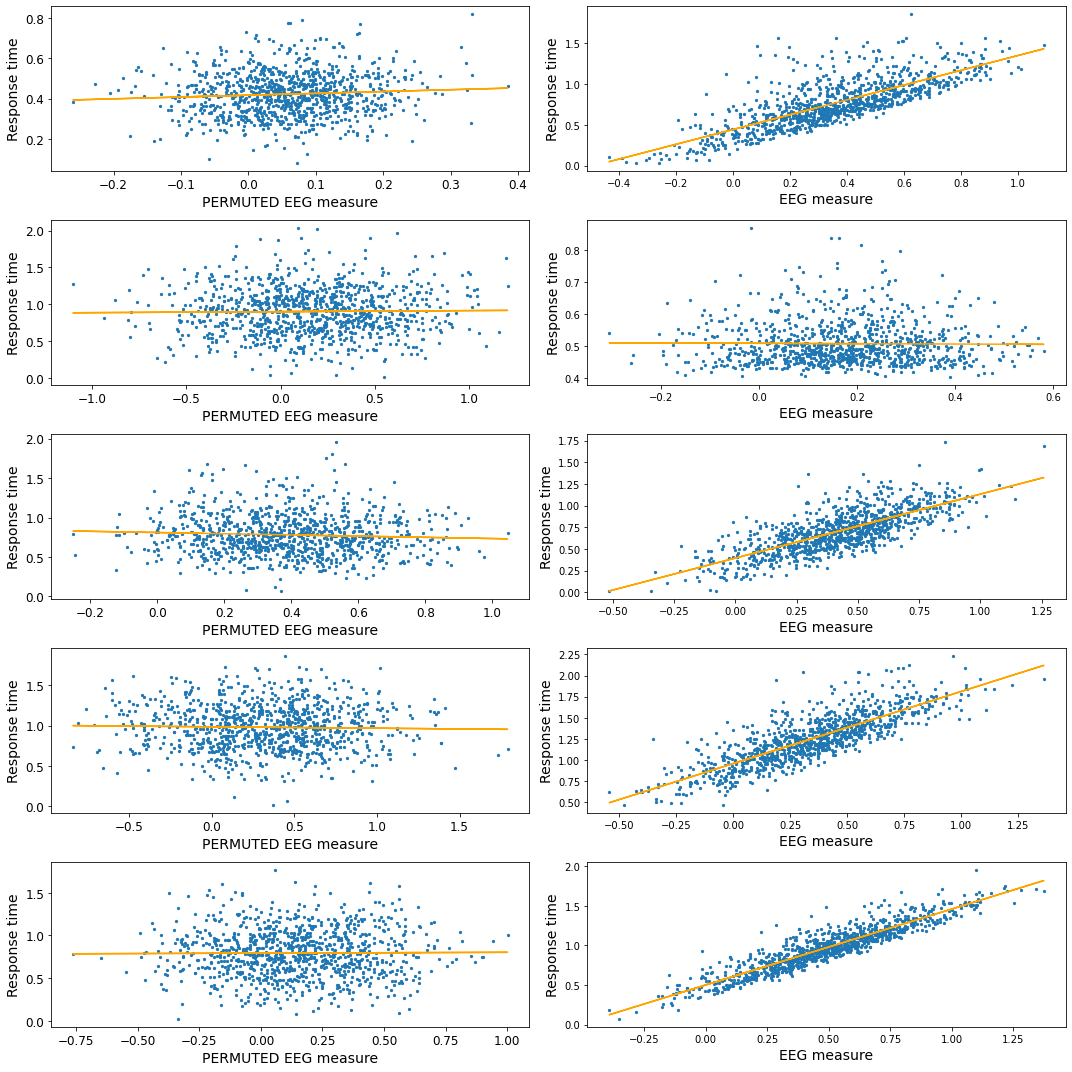

In [51]:
fig, axs = plt.subplots(5, 2, figsize=(15,15), tight_layout=True)

indx = np.array([2, 7, 8, 14, 10])
for i in range(5):
    # Model relationship between PERMUTED single-trial EEG and RT
    RT = np.abs(permuted_choicertEEG[indx[i],:,0])
    EEG = permuted_choicertEEG[indx[i],:,1]
    axs[i, 0].scatter(EEG, RT, s=5)
    # Linear regression
    design_matrix_permuted = np.vstack((np.ones(EEG.shape), EEG)).T
    simple_regression_permuted = sm.OLS(RT, design_matrix_permuted)
    regress_permuted_results = simple_regression_permuted.fit()
    #print(regress_permuted_results.summary())

    axs[i, 0].plot(EEG, regress_permuted_results.predict(), color='orange')
    axs[i,0].tick_params(axis='both', which='major', labelsize=12)
    axs[i,0].set_ylabel('Response time', fontsize=14)
    axs[i,0].set_xlabel('PERMUTED EEG measure', fontsize=14)
     # Model relationship between single-trial EEG and RT
    RT = np.abs(choicertEEG[indx[i],:,0])
    EEG = choicertEEG[indx[i],:,1]
    axs[i, 1].scatter(EEG, RT, s=5)

    # Linear regression
    design_matrix = np.vstack((np.ones(EEG.shape), EEG)).T
    simple_regression = sm.OLS(RT, design_matrix)
    regress_results = simple_regression.fit()
    #print(regress_results.summary())



    axs[i, 1].plot(EEG, regress_results.predict(), color='orange')

    axs[i,1].set_ylabel('Response time', fontsize=14)
    axs[i,1].set_xlabel('EEG measure', fontsize=14)

    
plt.savefig('Figures/permuted_nonpermuted_regression_EEG_cognition.png')    